## ResNET Training for MDSM
### 1. Instrall required pip package

In [1]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install --upgrade pandas
!pip install --upgrade torchsummary
!pip install --upgrade shap
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /usr/local/lib/python3.8/dist-packages (1.5.3)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: torchsummary in /usr/local/lib/python3.8/dist-packages (1.5.1)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: shap in /usr/local/lib/python3.8/dist-packages (0.41.0)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.8/dist-packages (3.7.0)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 2. import required python packages

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import shap
import time, sys

from ResNet import Bottleneck, ResNet, ResNet50, ResNet18, ResNet34, ResNet101, ResNet152
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchvision import models
from torchsummary import summary
from datetime import datetime
from pytz import timezone
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mdsm_width = 11
mdsm_height = 108
trans_stat = True

### 3. Define MDSMdata set for torch Dataset and Dataloader and other
* mix_random : For preventing overfitting (Mixing row randomly in MDSM metric
* flip_random : For preventing overfitting (Flip MDSM upside-down)

In [3]:
def mix_random(col, row, mdsm_body):
    size_suffle = random.randint(0,10)
    switchsource = torch.randint(0, row - 1, (size_suffle,))
    temp = np.zeros((1, col), np.float32)
    
    for i in range(0, int(size_suffle)):
        if i == switchsource[i]:
            continue
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[switchsource[i], :].copy()
        mdsm_body[switchsource[i], :] = temp.copy()
    return torch.tensor(mdsm_body)

def flip_random(col, row, mdsm_body):
    size_suffle = random.randint(0,12)
    if size_suffle % 4 != 0:
        return torch.tensor(mdsm_body)
    
    int_row = int(row)
    for i in range(0, int(int_row / 2)):
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[int_row - i - 1, :].copy()
        mdsm_body[int_row - i - 1, :] = temp.copy()
    return torch.tensor(mdsm_body)
    
class MDSMDataset(Dataset):
    def __init__(self, mdsmdata_file):
        self.df = pd.read_csv(mdsmdata_file)
        rating = self.df[['ReviewID', 'reviewStar']]
        self.rating = rating.drop_duplicates('ReviewID')
        if trans_stat == True:
            self.height = self.df['ReviewID'].value_counts().max()
        else:
            #Hardcoding for current dataset
            self.height = 108

        mdsm_body = self.df.drop(['reviewNo', 'reviewStar', 'mGNR'], axis=1)
        mdsm_body['imageCnt'] = (mdsm_body['imageCnt'] - mdsm_body['imageCnt'].min())/ (mdsm_body['imageCnt'].max() - mdsm_body['imageCnt'].min())
        mdsm_body['helpfulCnt'] = (mdsm_body['helpfulCnt'] - mdsm_body['helpfulCnt'].mean())/ mdsm_body['helpfulCnt'].std()
        body_height, body_width = mdsm_body.shape;
        self.width = body_width - 1
        mdsm_width = self.width
        if trans_stat == True:
            mdsm_height = self.height
        
        dummy_mdsd = np.zeros((body_height, self.height, self.width), np.float32)
        mdsm_index = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_count = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_index.fill(-1)

        max_index = int(0)
        for index, body in mdsm_body.iterrows():
            dummy_index = max_index
            if mdsm_index[int(body['ReviewID'])] != -1:
                dummy_index = mdsm_index[int(body['ReviewID'])]
            else:
                mdsm_index[int(body['ReviewID'])] = dummy_index
                max_index = max_index + 1

            dummy_mdsd[dummy_index, mdsm_count[dummy_index]] = body.drop('ReviewID')
            mdsm_count[dummy_index] = mdsm_count[dummy_index] + 1

        self.mdsm_body = dummy_mdsd
            
    def __len__(self):
        return self.rating.shape[0]

    
    def __getitem__(self, idx):
        if trans_stat == True:
            _tensor = flip_random(self.width, self.height, self.mdsm_body[idx])
        else:
            _tensor = torch.tensor(self.mdsm_body[idx])
        rtn_tensor = _tensor.unsqueeze(0)
        return rtn_tensor, self.rating.iloc[idx, 1]

### 4. Hyperparameter setting
* epochs, batch_size ResNet layer number
* select ResNet model
* print out Model strucuture

In [4]:
EPOCHS = 4
BATCH_SIZE = 512
net_type = "ResNet18"

if net_type == "ResNet18":
    net = ResNet18(6, 1).to('cuda')
    print("ResNet18 is used")
elif net_type == "ResNet34":
    net = ResNet34(6, 1).to('cuda')
    print("ResNet34 is used")
elif net_type == "ResNet50":
    net = ResNet50(6, 1).to('cuda')
    print("ResNet50 is used")
elif net_type == "ResNet101":
    net = ResNet101(6, 1).to('cuda')
    print("ResNet101 is used")
elif net_type == "ResNet152":
    net = ResNet152(6, 1).to('cuda')
    print("ResNet152 is used")

summary(net, (1, mdsm_height, mdsm_width))

ResNet18 is used
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 54, 6]           3,136
       BatchNorm2d-2            [-1, 64, 54, 6]             128
              ReLU-3            [-1, 64, 54, 6]               0
         MaxPool2d-4            [-1, 64, 27, 3]               0
            Conv2d-5            [-1, 64, 27, 3]          36,864
       BatchNorm2d-6            [-1, 64, 27, 3]             128
           Dropout-7            [-1, 64, 27, 3]               0
           Dropout-8            [-1, 64, 27, 3]               0
            Conv2d-9            [-1, 64, 27, 3]          36,864
      BatchNorm2d-10            [-1, 64, 27, 3]             128
       BasicBlock-11            [-1, 64, 27, 3]               0
           Conv2d-12            [-1, 64, 27, 3]          36,864
      BatchNorm2d-13            [-1, 64, 27, 3]             128
          Dropout-14  

### 5. Load MDSM dataset from preprocesed csv file
* split train and test dataset into 8:2 ratio
* 6 kinds of classess [0, 1, 2, 3, 4, 5]

In [ ]:
print('-- Loading dataset--')

dataset = MDSMDataset('amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size

In [5]:
print("Train(", train_size, ") vs Test(", test_size, ")")

print('-- Building train and test dataset / dataloader--')
train_dataset, test_dataset = random_split(dataset, [int(train_size),int(test_size)])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

classes = ['0', '1', '2', '3', '4', '5']


-- Loading dataset--
Train( 13188 ) vs Test( 3297 )
-- Building train and test dataset / dataloader--


### 6. Define mae and mse calcuating function

In [6]:
def calcu_metric(outputs, labels):
    mae = abs(outputs - labels)
    mse = torch.pow((outputs - labels), 2)
    mape = abs((outputs-labels)/labels)
    mbe = outputs - labels
    return mae, mse, mape, mbe

### 7. Do ResNet training

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

correct = 0
total = 0


print('-- Start training : ', EPOCHS, 'epochs')
start = time.time()

mse_history = {'train': [], 'val': []}
rmse_history = {'train': [], 'val': []}
mae_history = {'train': [], 'val': []}
mape_history = {'train': [], 'val': []}
mbe_history = {'train': [], 'val': []}
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

for epoch in range(EPOCHS):
    losses = []
    
    mse = np.zeros(train_size, np.float32)
    mae = np.zeros(train_size, np.float32)
    mape = np.zeros(train_size, np.float32)
    mbe = np.zeros(train_size, np.float32)
    rmse = np.zeros(train_size, np.float32)
    
    
    val_mse = np.zeros(test_size, np.float32)
    val_mae = np.zeros(test_size, np.float32)
    val_mape = np.zeros(test_size, np.float32)
    val_mbe = np.zeros(test_size, np.float32)
    val_rmse = np.zeros(train_size, np.float32)
    
    metric_index = 0
    
    running_loss = 0
    train_loss = 0
    train_acc = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss += loss.item()
        
        pred = outputs.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(labels.data.view_as(pred)).sum()
        

        _mae, _mse, _mape, _mbe = calcu_metric(pred.squeeze(), labels)
        #print(_mse.detach().cpu().numpy())
        mae[metric_index:metric_index+len(inputs)] = _mae.detach().cpu().numpy()
        mse[metric_index:metric_index+len(inputs)] = _mse.detach().cpu().numpy()
        mape[metric_index:metric_index+len(inputs)] = _mape.detach().cpu().numpy()
        mbe[metric_index:metric_index+len(inputs)] = _mbe.detach().cpu().numpy()
        #print(torch.tensor(mse))
        metric_index += len(inputs)
        
        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}/{EPOCHS}, {i}](epoch, minibatch): ', f'{running_loss / 100:.5f}')
            running_loss = 0.0

    mae_epoch = torch.mean(torch.tensor(mae))
    mse_epoch = torch.mean(torch.tensor(mse))
    rmse_epoch = torch.sqrt(mse_epoch)
    mape_epoch = torch.mean(torch.tensor(mape))*100
    mbe_epoch = torch.mean(torch.tensor(mbe))
    
    mse_history['train'].append(mse_epoch)
    rmse_history['train'].append(rmse_epoch)
    mae_history['train'].append(mae_epoch)
    mape_history['train'].append(mape_epoch)
    mbe_history['train'].append(mbe_epoch)
    
    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
    
    metric_index = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = net(images)

            pred = outputs.data.max(1, keepdim=True)[1]
            _mae, _mse, _mape, _mbe  = calcu_metric(pred.squeeze(), labels)
            val_mae[metric_index:metric_index+len(images)] = _mae.detach().cpu().numpy()
            val_mse[metric_index:metric_index+len(images)] = _mse.detach().cpu().numpy()
            val_mape[metric_index:metric_index+len(images)] = _mape.detach().cpu().numpy()
            val_mbe[metric_index:metric_index+len(images)] = _mbe.detach().cpu().numpy()
            metric_index += len(images)           
        
    val_mae_epoch = torch.mean(torch.tensor(val_mae))
    val_mse_epoch = torch.mean(torch.tensor(val_mse))
    val_rmse_epoch = torch.sqrt(val_mse_epoch)
    val_mape_epoch = torch.mean(torch.tensor(val_mape))*100
    val_mbe_epoch = torch.mean(torch.tensor(val_mbe))
    mse_history['val'].append(val_mse_epoch)
    rmse_history['val'].append(val_rmse_epoch)
    mae_history['val'].append(val_mae_epoch)
    mape_history['val'].append(val_mape_epoch)
    mbe_history['val'].append(val_mbe_epoch)
    
    acc_history['train'].append((100. * train_acc / len(trainloader.dataset)).detach().cpu().numpy())
    
    train_loss /= len(trainloader.dataset)
    if EPOCHS > 50:
        if epoch % 5 == 0:
            print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")
    else:
        print('Epoch: {}/{} Avg. loss:{:.4f} Acc.: {:.4f}% '.format(epoch, EPOCHS, train_loss, 100. * train_acc / len(trainloader.dataset)), f"MAE : {mae_epoch.item():.3f}", f"MSE : {mse_epoch.item():.3f}", f"VAL_MAE : {val_mae_epoch.item():.3f}", f"VAL_MSE : {val_mse_epoch.item():.3f}" ")")

print('Training Done')
trans_stat = False
end = time.time()
print(f"{net_type} training takes {end - start:.5f} sec")

-- Start training :  4 epochs
Epoch: 0/4 Avg. loss:0.0033 Acc.: 53.3743%  MAE : 1.266 MSE : 0.744 VAL_MAE : 1.122 VAL_MSE : 0.657)
Epoch: 1/4 Avg. loss:0.0026 Acc.: 57.7874%  MAE : 1.127 MSE : 0.666 VAL_MAE : 1.038 VAL_MSE : 0.615)
Epoch: 2/4 Avg. loss:0.0023 Acc.: 60.0318%  MAE : 1.030 MSE : 0.619 VAL_MAE : 1.008 VAL_MSE : 0.602)
Epoch: 3/4 Avg. loss:0.0023 Acc.: 61.0934%  MAE : 0.980 MSE : 0.595 VAL_MAE : 0.972 VAL_MSE : 0.583)
Training Done
ResNet18 training takes 4.30345 sec


### 8. Save model metrics into csv file
* Hyperparameter were written in filename

In [8]:
now = datetime.now(timezone('Asia/Seoul'))
time_str = now.strftime('%Y-%m-%d_%H%M%S')

hist_csv = np.stack([mae_history['val'], mse_history['val'], rmse_history['val'], mape_history['val'], mbe_history['val'],
                     mae_history['train'], mse_history['train'], rmse_history['train'], mape_history['train'],mbe_history['train'],
                     acc_history['train']], 1)
hist_csv_df = pd.DataFrame(hist_csv)
hist_csv_df.columns = ['validation_mae', 'validation_mse', 'validation_rmse', 'validation_mape', 'validation_mbe',
                       'train_mae', 'train_mse', 'train_rmse', 'train_mape', 'train_mbe', 'train_accuracy']

hist_csv_df.to_csv("training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.csv"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str), index=False)
print("training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.csv saved"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))

torch.save({
                "epoch": EPOCHS,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
           "check_points/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.pt"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
torch.save({
                "epoch": EPOCHS,
                "model_state_dict": net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },"check_points/latest.pt")
torch.save(net, "check_points/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.model"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
torch.save(net, "check_points/latest.model")

print("check_points/amazon_hmdvr_df_tokenized_sentiment_score_model-{}_epochs-{}-batch-{}-{}.pt & check_points/latest.pt saved"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))

training_metrics/amazon_hmdvr_df_tokenized_sentiment_score_model-ResNet18_epochs-4-batch-512-2023-02-24_10:43:24.csv saved
check_points/amazon_hmdvr_df_tokenized_sentiment_score_model-ResNet18_epochs-4-batch-512-2023-02-24_10:43:24.pt & check_points/latest.pt saved


### 9. Plot model metrics

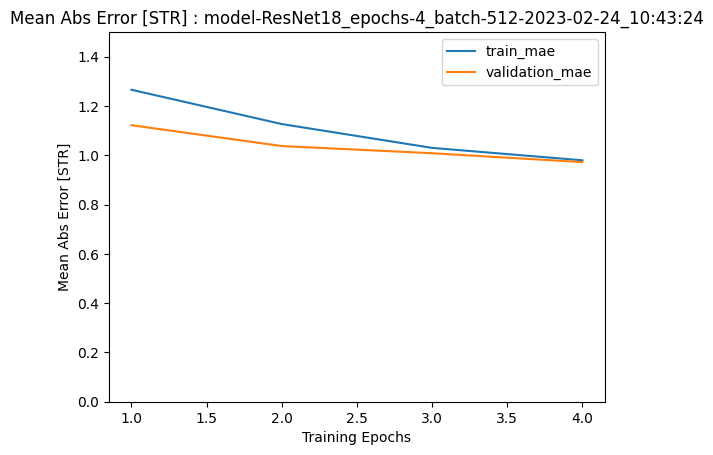

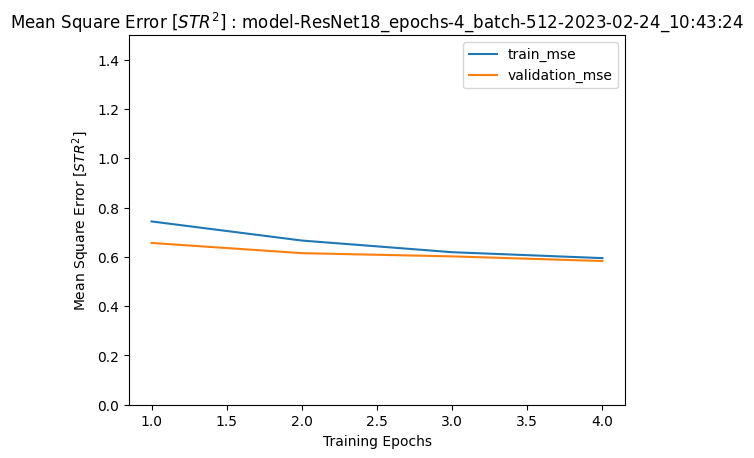

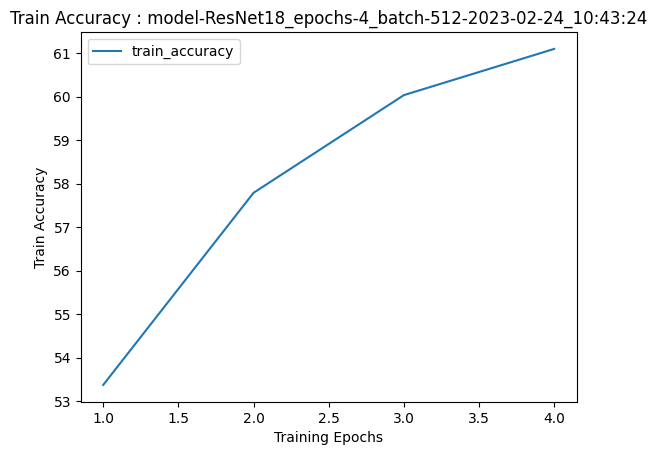

In [9]:
plt.title("Mean Abs Error [STR] : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),mae_history["train"],label="train_mae")
plt.plot(range(1,EPOCHS+1),mae_history["val"],label="validation_mae")
plt.ylabel("Mean Abs Error [STR]")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.show()

plt.title("Mean Square Error [$STR^2$] : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),mse_history["train"],label="train_mse")
plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation_mse")
plt.ylabel("Mean Square Error [$STR^2$]")
plt.xlabel("Training Epochs")
plt.ylim([0,5])
plt.legend()
plt.show()


plt.title("Root Mean Squared Error: model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),rmse_history["train"],label="train_rmse")
plt.plot(range(1,EPOCHS+1),rmse_history["val"],label="validation_rmse")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.show()

plt.title("Mean Absolute Percentage Error : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),mape_history["train"],label="train_mape")
plt.plot(range(1,EPOCHS+1),mape_history["val"],label="validation_mape")
plt.ylabel("Mean Absolute Percentage Error(%)")
plt.xlabel("Training Epochs")
plt.ylim([0,100])
plt.legend()
plt.show()

plt.title("Mean Bias Error : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),mbe_history["train"],label="train_mbe")
plt.plot(range(1,EPOCHS+1),mbe_history["val"],label="validation_mbe")
plt.ylabel("Mean Bias Error")
plt.xlabel("Training Epochs")
plt.ylim([0,1.5])
plt.legend()
plt.show()

plt.title("Train Accuracy : model-{}_epochs-{}_batch-{}-{}"
                   .format(net_type, EPOCHS, BATCH_SIZE, time_str))
plt.plot(range(1,EPOCHS+1),acc_history["train"],label="train_accuracy")
#plt.plot(range(1,EPOCHS+1),mse_history["val"],label="validation mse")
plt.ylabel("Train Accuracy")
plt.xlabel("Training Epochs")
#plt.ylim([0,1.5])
plt.legend()
plt.show()

### 10. Using SHAP for XAI 

___Shap command has to been excuted by manually after training finishing(need time gap)___

In [10]:
df = pd.read_csv('amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
dff = df.drop(['reviewNo', 'ReviewID', 'reviewStar', 'mGNR'], axis=1)

In [137]:
batch = next(iter(testloader))
images, _ = batch

#max_size = 100
max_size = 200
#max_size = BATCH_SIZE - 50
#max_size = 400
shap_test_size = max_size + 50

background = images[:max_size]
test_images = images[max_size:shap_test_size]

#e = shap.DeepExplainer(net, background.to(device))
e = shap.DeepExplainer(net, background.to(device))
shap_values = e.shap_values(test_images)
#tt = e(test_images)

In [138]:
shap.force_plot(e.expected_value[0],
                shap_values[0][0][0])

In [12]:
shap.initjs()

In [146]:
shap.decision_plot( e.expected_value,
                   shap_values[0],
                   images[:][0][0],
                   feature_names=dff.columns
                  )

TypeError: The features arg uses an unsupported type.

In [147]:
shap.dependence_plot(0 , shap_values[0][0], images[0][0][0])

TypeError: order must be str, not int

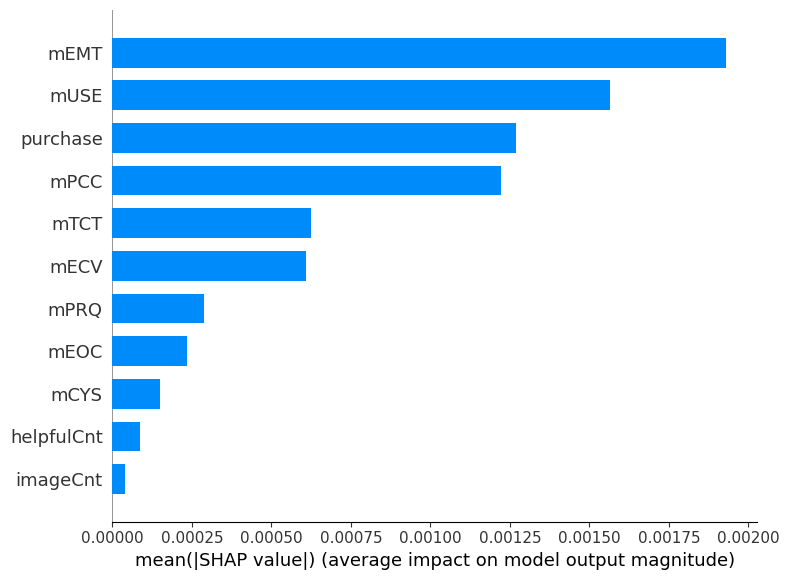

In [126]:
shap.summary_plot(shap_values[0][0][0], images[:][0][0], feature_names=dff.columns,plot_type='bar')

In [77]:
shap.plots.bar(e)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


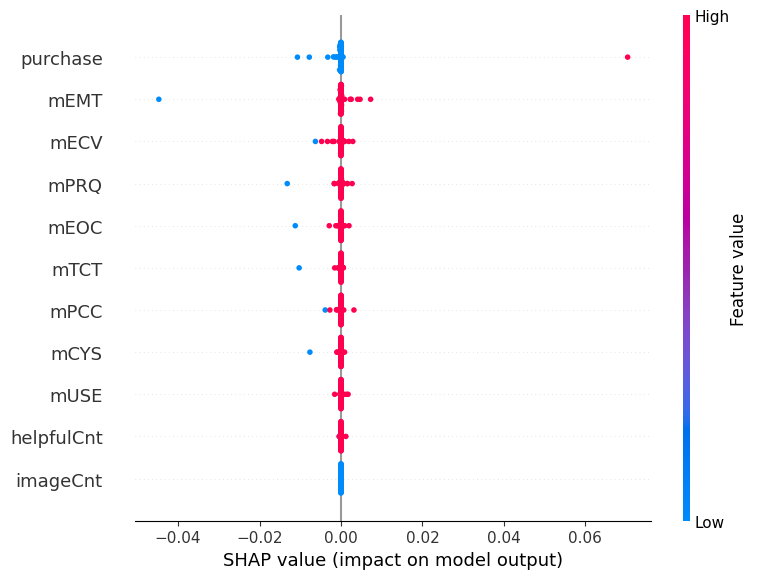

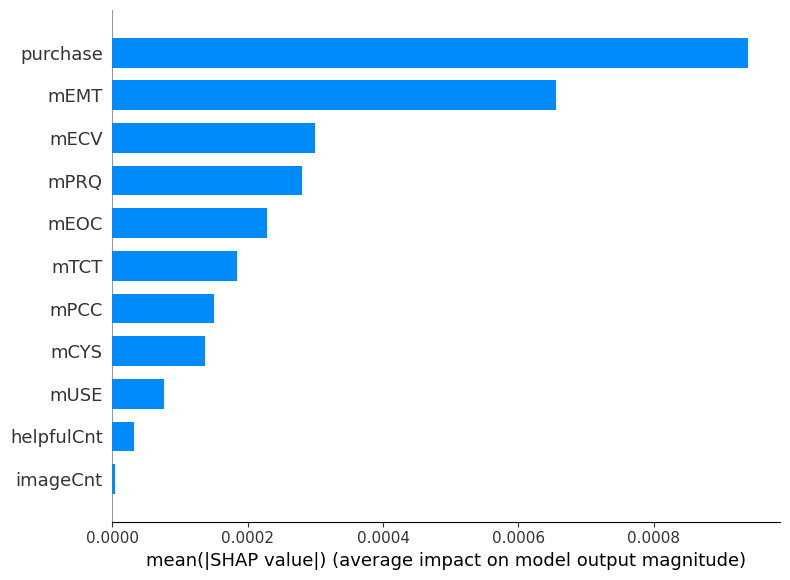

In [13]:
shap.summary_plot(shap_values[0][0][0], images[:][0][0], feature_names=dff.columns)
shap.summary_plot(shap_values[0][0][0], images[:][0][0], feature_names=dff.columns,plot_type='bar')

print('-- Building shap test dataset / dataloader--')
for i in range(5):
    dataset_shap = MDSMDataset(f'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar{i+1}.csv')
    print(f'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar{i+1}.csv is used for shap analysis')

    shap_shap_loader = torch.utils.data.DataLoader(dataset_shap, batch_size = len(dataset_shap), shuffle=True, num_workers=0)

    batch_shap = next(iter(shap_shap_loader))
    images_shap, _ = batch_shap

    max_size_shap = len(dataset_shap)
  
    test_images_shap = images_shap[:max_size_shap]
    shap_values_shap = e.shap_values(test_images_shap)
    
    clear_output(wait=True)
    print(f'amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized_reviewStar{i+1}.csv is used for shap analysis')
    
    shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns)
    shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns,plot_type='bar')
    
    plt.clf()
    shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns,show=False)
    plt.savefig("graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-data_{}-{}_model-{}_epochs-{}-batch-{}-{}.png"
            .format(i+1, max_size, net_type, EPOCHS, BATCH_SIZE, time_str), dpi=300)
    print("graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-data_{}-{}_model-{}_epochs-{}-batch-{}-{}.png is saved"
            .format(i+1, max_size, net_type, EPOCHS, BATCH_SIZE, time_str))
    
    plt.clf()
    shap.summary_plot(shap_values_shap[0][0][0], images_shap[:][0][0], feature_names=dff.columns,plot_type='bar',show=False)
    plt.savefig("graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-bar-data_{}-{}_model-{}_epochs-{}-batch-{}-{}.png"
            .format(i+1, max_size, net_type, EPOCHS, BATCH_SIZE, time_str), dpi=300)
    print("graphs/amazon_hmdvr_df_tokenized_sentiment_score_shap_summary-bar-data_{}-{}_model-{}_epochs-{}-batch-{}-{}.png is saved"
            .format(i+1, max_size, net_type, EPOCHS, BATCH_SIZE, time_str))